# Importer les bibliothèques nécessaires

In [31]:
import pandas as pd
import numpy as np
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') # Appliquer le style 'ggplot' à Matplotlib

# 1. Préparation des données

In [32]:
# Charger les données
data = pd.read_csv("D:/INSSEDS/datasets/bank.csv")

In [33]:
# Visualiser les premières lignes du DataFrame pour inspection
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


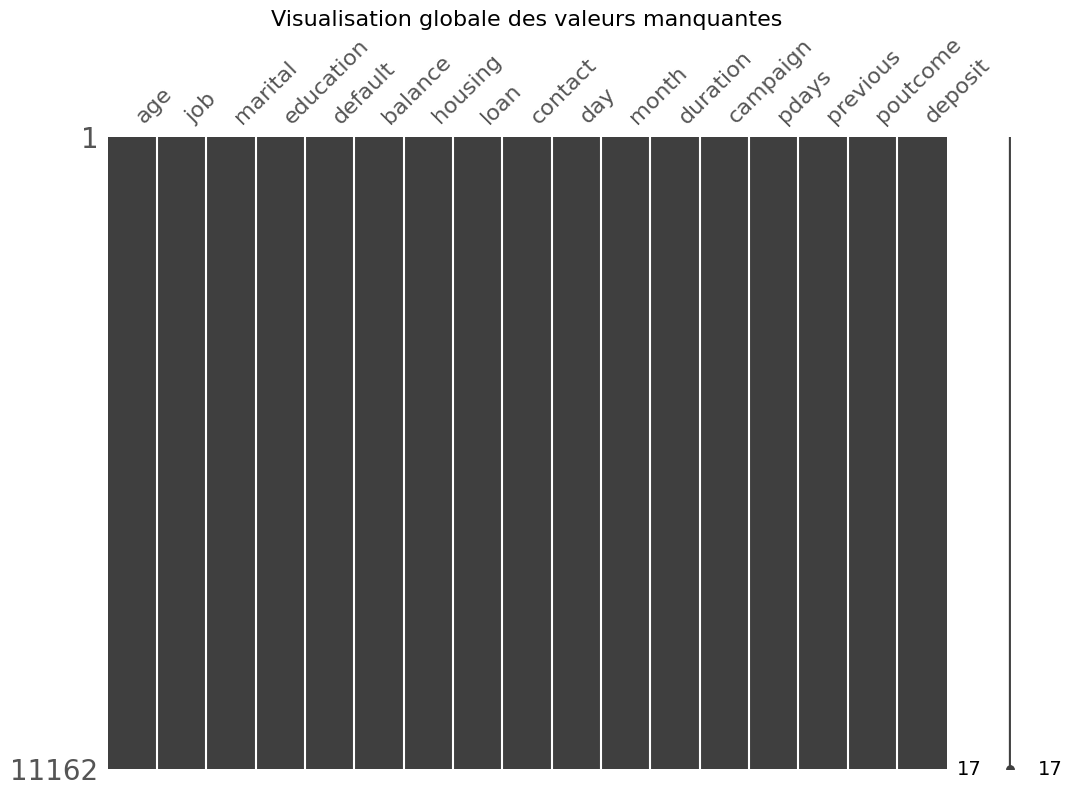

In [35]:
import matplotlib.pyplot as plt
import missingno as msno

# Visualiser les valeurs manquantes globalement
msno.matrix(data, figsize=(12, 8))

# Ajouter un titre pour la visualisation globale
plt.title('Visualisation globale des valeurs manquantes', fontsize=16)

# Ajuster manuellement les espaces
plt.subplots_adjust(top=0.9)

# Afficher le graphique
plt.show()


##1.2. Encodage des variables catégoriques

In [36]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Encodage des variables catégorielles
label_encoder = LabelEncoder()
data['job'] = label_encoder.fit_transform(data['job'])
data['marital'] = label_encoder.fit_transform(data['marital'])
data['education'] = label_encoder.fit_transform(data['education'])
data['default'] = label_encoder.fit_transform(data['default'])
data['housing'] = label_encoder.fit_transform(data['housing'])
data['loan'] = label_encoder.fit_transform(data['loan'])
data['contact'] = label_encoder.fit_transform(data['contact'])
data['month'] = label_encoder.fit_transform(data['month'])
data['poutcome'] = label_encoder.fit_transform(data['poutcome'])

In [37]:
# Variables cibles et features
X = data.drop('deposit', axis=1)  # Features
y = data['deposit']  # Cible

# 2. Explorer les relations entre les variables

##2.1. Calculer la corrélation entre chaque variable et la variable cible

In [38]:
# Convertir la variable cible en numérique si elle est catégorique
data['deposit'] = data['deposit'].map({'yes': 1, 'no': 0})  # Supposons que 'yes' = 1 et 'no' = 0

# Convertir les variables catégorielles en numériques
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)  # Encodage one-hot

# Calcul de la corrélation
correlation_matrix = data_encoded.corr()

# Trier les corrélations avec 'deposit' par ordre décroissant
correlation_with_target = correlation_matrix['deposit'].sort_values(ascending=False)

# Afficher les corrélations
print(correlation_with_target)

deposit        1.000000
duration       0.451919
poutcome_2     0.286642
pdays          0.151593
previous       0.139867
month_7        0.135438
month_10       0.133783
month_11       0.126901
job_5          0.103827
job_8          0.099953
marital_2      0.094632
education_2    0.094598
month_2        0.086964
balance        0.081129
month_3        0.051710
poutcome_1     0.044059
job_4          0.036301
age            0.034901
job_10         0.033487
contact_1      0.016420
education_3    0.014355
job_11         0.001889
job_6         -0.004707
job_9         -0.011557
month_1       -0.016621
month_6       -0.018982
month_4       -0.021803
job_3         -0.024155
month_9       -0.028278
job_2         -0.034443
default_1     -0.040680
job_7         -0.044531
month_5       -0.047368
education_1   -0.051952
day           -0.056326
marital_1     -0.092157
job_1         -0.100840
loan_1        -0.110580
campaign      -0.128081
month_8       -0.170507
housing_1     -0.203888
poutcome_3    -0

##2.2. Afficher la matrice de corrélation entre les variables indépendantes

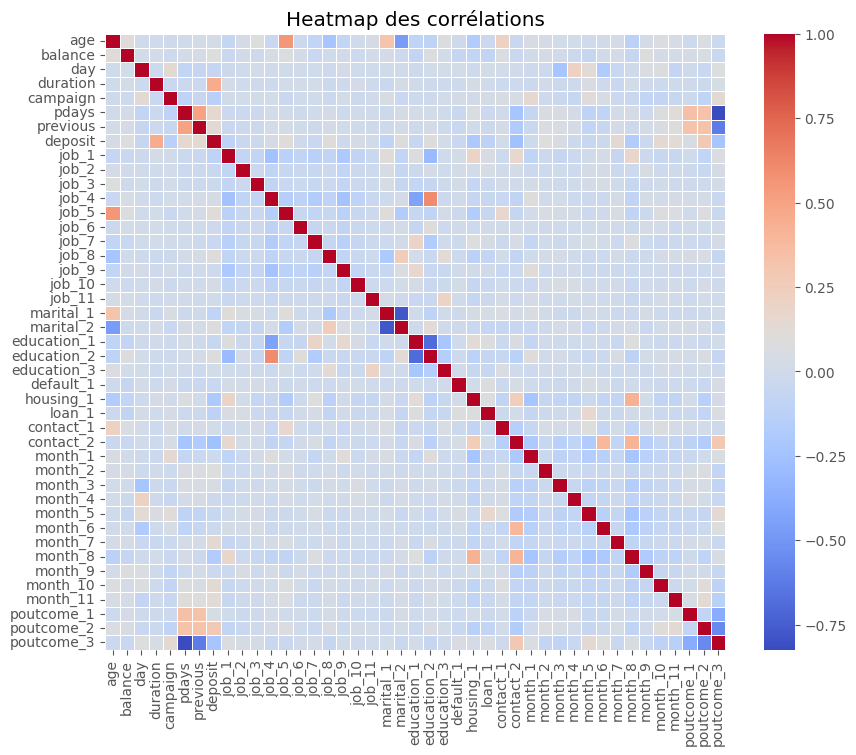

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))  # Ajuster la taille
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, annot=False)
plt.title("Heatmap des corrélations")
plt.show()


# 3. Construction du modèle de RandomForest

##3.1. Partitionnement des données en ensemble d'entraînement et de test

In [40]:
# Normalisation des variables numériques
scaler = StandardScaler()
X[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']] = scaler.fit_transform(X[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']])


In [41]:
# Diviser les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##3.2. Le modèle de RandomForest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialiser et entraîner le modèle
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [43]:
# Faire des prédictions sur l'ensemble de test
y_pred_rf = model_rf.predict(X_test)

In [44]:
# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.8393550313526426
Confusion Matrix:
 [[1427  315]
 [ 223 1384]]


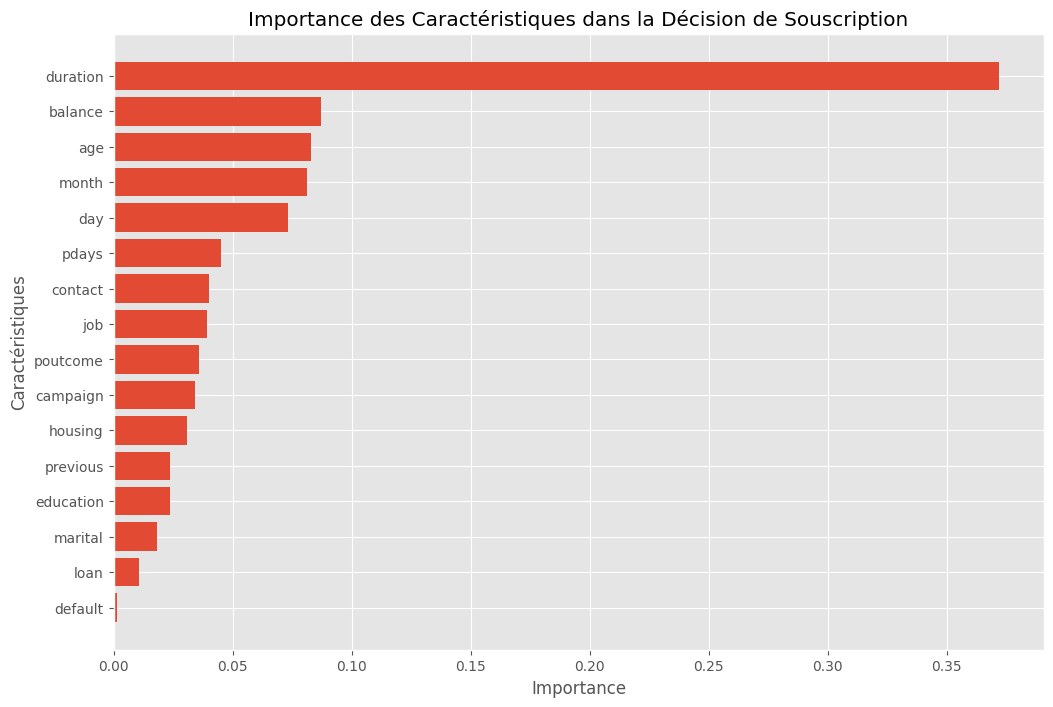

In [45]:
# Extraire l'importance des caractéristiques
importances = model_rf.feature_importances_

# Créer un DataFrame pour visualiser les importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Trier les caractéristiques par ordre décroissant d'importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualiser l'importance des caractéristiques
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')
plt.title('Importance des Caractéristiques dans la Décision de Souscription')
plt.gca().invert_yaxis()  # Pour afficher les caractéristiques les plus importantes en haut
plt.show()


# 4. Modélisation avec des réseaux de neurones (Deep Learning)

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam

# Création du modèle de réseau de neurones
model_nn = Sequential()
model_nn.add(Input(shape=(X_train.shape[1],)))  # Utilisation de la couche Input pour définir la forme d'entrée
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))  # Sortie binaire (0 ou 1)

# Compilation du modèle
model_nn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [47]:
y_train = y_train.map({'yes': 1, 'no': 0})
y_test = y_test.map({'yes': 1, 'no': 0})


In [48]:
print(X_train.dtypes)  # Vérifier les types de colonnes
X_train.head()  # Voir les premières lignes pour détecter d'éventuels problèmes


age          float64
job            int32
marital        int32
education      int32
default        int32
balance      float64
housing        int32
loan           int32
contact        int32
day            int64
month          int32
duration     float64
campaign     float64
pdays        float64
previous     float64
poutcome       int32
dtype: object


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
7968,1.323619,9,1,1,0,-0.179377,1,0,0,9,5,2.592835,-0.554168,-0.481184,-0.36326,3
1456,-0.607072,9,2,2,0,-0.187128,1,0,0,13,0,0.970884,-0.554168,-0.481184,-0.36326,3
361,-0.019470,1,2,1,0,-0.450672,1,0,2,1,5,0.308275,2.384895,-0.481184,-0.36326,3
812,0.400245,9,2,2,0,0.894642,0,0,0,18,1,0.380298,1.650129,-0.481184,-0.36326,3
1092,-1.110730,11,2,1,0,0.910455,0,0,0,28,4,1.143738,-0.554168,-0.481184,-0.36326,3


In [49]:
# Entraînement du modèle
model_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6528 - loss: 0.6158 - val_accuracy: 0.7883 - val_loss: 0.4777
Epoch 2/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7969 - loss: 0.4541 - val_accuracy: 0.7934 - val_loss: 0.4571
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8017 - loss: 0.4537 - val_accuracy: 0.7874 - val_loss: 0.4563
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7927 - loss: 0.4576 - val_accuracy: 0.7826 - val_loss: 0.4586
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8056 - loss: 0.4352 - val_accuracy: 0.7996 - val_loss: 0.4363
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8078 - loss: 0.4313 - val_accuracy: 0.7999 - val_loss: 0.4327
Epoch 7/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8123 - loss: 0.4207 - val_accuracy: 0.7993 - val_loss: 0.4494
Epoch 8/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8199 - loss: 0.4094 - val_accuracy: 0.

In [50]:
# Évaluation du modèle
loss, accuracy = model_nn.evaluate(X_test, y_test)
print("Neural Network Accuracy:", accuracy)

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.7875 - loss: 0.4528
Neural Network Accuracy: 0.8053150177001953


# 5. Comparaison des modèles

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialiser et entraîner le modèle
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Affichage des résultats
print("### Random Forest ###")
# Faire des prédictions sur l'ensemble de test
y_pred_rf = model_rf.predict(X_test)
# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


# Affichage des résultats de Neural Network
print("### Neural Network ###")
loss, accuracy = model_nn.evaluate(X_test, y_test)
print("Neural Network Accuracy:", accuracy)


### Random Forest ###
Accuracy: 0.8393550313526426
Confusion Matrix:
 [[1427  315]
 [ 223 1384]]
### Neural Network ###
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.7875 - loss: 0.4528
Neural Network Accuracy: 0.8053150177001953


In [52]:
# Prédiction avec le modèle Random Forest sur l'ensemble de test
y_pred_rf = model_rf.predict(X_test)

# Affichage des résultats de la prédiction
print("### Prédictions sur l'ensemble de test ###")
print(f"Prédictions : {y_pred_rf}")

# Évaluation du modèle
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("\n### Résultats du modèle Random Forest ###")
print(f"Accuracy: {accuracy_rf}")
print(f"Confusion Matrix:\n{conf_matrix_rf}")


### Prédictions sur l'ensemble de test ###
Prédictions : [1 1 1 ... 0 0 1]

### Résultats du modèle Random Forest ###
Accuracy: 0.8393550313526426
Confusion Matrix:
[[1427  315]
 [ 223 1384]]


In [53]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
7968,1.323619,9,1,1,0,-0.179377,1,0,0,9,5,2.592835,-0.554168,-0.481184,-0.36326,3
1456,-0.607072,9,2,2,0,-0.187128,1,0,0,13,0,0.970884,-0.554168,-0.481184,-0.36326,3
361,-0.019470,1,2,1,0,-0.450672,1,0,2,1,5,0.308275,2.384895,-0.481184,-0.36326,3
812,0.400245,9,2,2,0,0.894642,0,0,0,18,1,0.380298,1.650129,-0.481184,-0.36326,3
1092,-1.110730,11,2,1,0,0.910455,0,0,0,28,4,1.143738,-0.554168,-0.481184,-0.36326,3


In [54]:
# 1. Prédire les valeurs avec le modèle Random Forest
y_pred_rf = model_rf.predict(X_test)  # ou X_train si vous souhaitez utiliser le jeu d'entraînement

# 2. Ajouter les prédictions au jeu de données initial
X_test['predicted_deposit'] = y_pred_rf  # Remarquez que vous pouvez aussi le faire sur X_train si vous voulez

# Afficher le DataFrame avec les prédictions ajoutées
X_test.head()  # Affiche les premières lignes du DataFrame avec la nouvelle colonne


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,predicted_deposit
5527,1.995163,5,0,1,0,-0.243247,0,0,0,5,5,-0.547355,-0.554168,-0.481184,-0.363260,3,1
4541,-0.271300,1,1,1,0,0.030528,0,0,2,16,6,2.739761,2.384895,-0.481184,-0.363260,3,1
1964,-0.523129,1,2,1,0,1.064861,1,0,0,14,8,0.242014,-0.554168,2.286545,0.073059,0,1
5007,0.484188,1,1,1,0,2.077489,0,0,0,8,1,1.186952,-0.186785,-0.481184,-0.363260,3,1
8928,-0.523129,9,1,2,0,-0.017220,1,0,2,12,8,-0.829684,0.180598,-0.481184,-0.363260,3,0


In [55]:
import pandas as pd

# Exemple de nouvelle valeur sous forme de DataFrame
nouvelle_valeur = pd.DataFrame({
    'age': [30],
    'job': [1],
    'marital': [1],
    'education': [2],
    'default': [0],
    'balance': [1500],
    'housing': [1],
    'loan': [0],
    'contact': [1],
    'day': [5],
    'month': [5],
    'duration': [100],
    'campaign': [4],
    'pdays': [-1],
    'previous': [0],
    'poutcome': [0]
})

# Prédiction avec le modèle Random Forest
prediction = model_rf.predict(nouvelle_valeur)

# Affichage de la prédiction
print("### Prédiction pour la nouvelle valeur ###")
print(f"Prédiction : {prediction[0]}")


### Prédiction pour la nouvelle valeur ###
Prédiction : 1


# 6. Vérification des hypothèses du RandomForest

## 6.1. Indépendance des Arbres

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Initialisation du modèle Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=True)

# Entraînement du modèle
model_rf.fit(X_train, y_train)

# Vérification de l'utilisation de l'échantillonnage bootstrap
print("Bootstrap utilisé :", model_rf.bootstrap)


Bootstrap utilisé : True


## 6.2. Diversité des Arbres

In [57]:
import numpy as np

# Calcul de l'importance des caractéristiques
importances = model_rf.feature_importances_

# Vérification de la diversité en examinant les importances
print("Importances des caractéristiques :", importances)
print("Diversité (écart-type des importances) :", np.std(importances))


Importances des caractéristiques : [0.08276161 0.0390934  0.01840041 0.0237238  0.00136008 0.08718752
 0.03100277 0.01065491 0.04000642 0.07316959 0.08131375 0.37212553
 0.0343591  0.04524098 0.02386559 0.03573453]
Diversité (écart-type des importances) : 0.08388043615311168


## 6.3. Nombre Suffisant d'Arbres

In [58]:
# Assurez-vous que X_test a les mêmes colonnes que X_train
X_test = X_test[X_train.columns]

# Entraînement du modèle Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_rf = model_rf.predict(X_test)

# Évaluation du modèle Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("### Random Forest ###")
print(f"Accuracy: {accuracy_rf}")
print(f"Confusion Matrix:\n{conf_matrix_rf}")


### Random Forest ###
Accuracy: 0.8393550313526426
Confusion Matrix:
[[1427  315]
 [ 223 1384]]


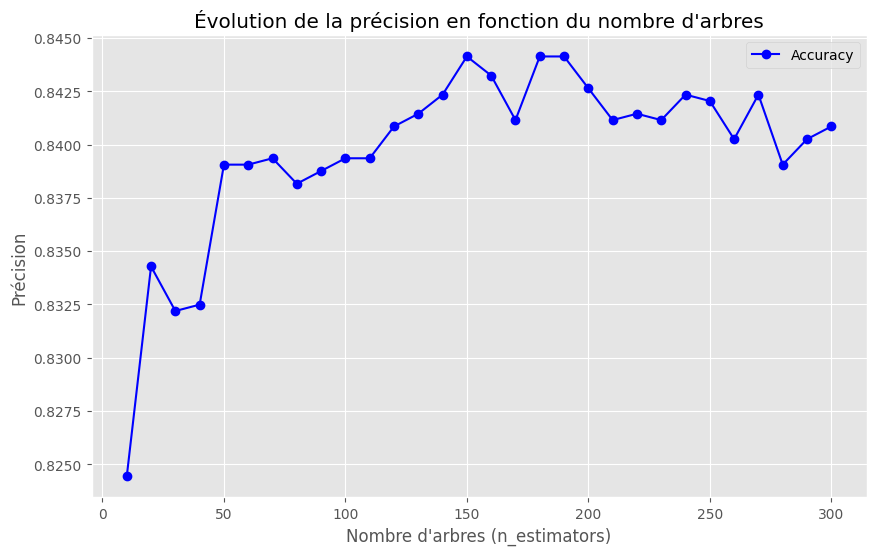

Meilleure précision de 84.41% obtenue avec 150 arbres.


In [59]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Listes pour stocker les résultats
n_estimators_range = range(10, 301, 10)  # De 10 à 300 arbres (par paliers de 10)
accuracies = []

# Test de différents nombres d'arbres
for n in n_estimators_range:
    model_rf = RandomForestClassifier(n_estimators=n, random_state=42)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    accuracies.append(accuracy_rf)

# Tracer la courbe de performance
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, accuracies, marker='o', color='b', label='Accuracy')
plt.title("Évolution de la précision en fonction du nombre d'arbres")
plt.xlabel("Nombre d'arbres (n_estimators)")
plt.ylabel("Précision")
plt.grid(True)
plt.legend()
plt.show()

# Affichage de la meilleure précision
best_accuracy = max(accuracies)
best_n_estimators = n_estimators_range[accuracies.index(best_accuracy)]
print(f"Meilleure précision de {best_accuracy*100:.2f}% obtenue avec {best_n_estimators} arbres.")
